# Notebook with figures for this work

In [1]:
using Pkg
# cd("/g/data/e14/jb2381/CabbelingExperiments")
# Pkg.activate(@__DIR__)
Pkg.activate(joinpath(@__DIR__, "../"))
using NCDatasets, CairoMakie, TwoLayerDirectNumericalShenanigans, StatsBase, Printf, GibbsSeaWater, JLD2
using TwoLayerDirectNumericalShenanigans: tanh_initial_condition

  Activating project at `~/Documents/PhD data and code/CabbelingExperiments`
┌ Info: Oceananigans will use 8 threads
└ @ Oceananigans /Users/Joey/.julia/packages/Oceananigans/YuCm8/src/Oceananigans.jl:271


## Change in thermal expansion and haline contraction coefficients

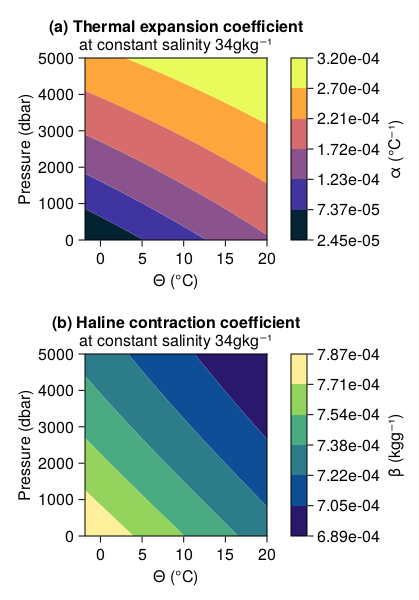

In [6]:
Sₐ = 34
N = 1000
p = range(0, 5000, length = 1000)
Θ_freezing = gsw_ct_freezing(Sₐ, 0, 0)
Θ = range(Θ_freezing, 20, length = 1000)
Θ_grid = ones(N) .* Θ'
p_grid = p .* ones(N)'
α = gsw_alpha.(Sₐ, Θ_grid, p_grid)
β = gsw_beta.(Sₐ, Θ_grid, p_grid)
fig = Figure(size = (500, 800))
levels = 7
## Thermal expansion coefficient
ax = Axis(fig[1, 1], 
            title = "(a) Thermal expansion coefficient",
            subtitle = "at constant salinity $(Sₐ)gkg⁻¹",
            xlabel = "Θ (°C)",
            ylabel = "Pressure (dbar)",
            aspect = 1)
α_levels = range(extrema(α)..., length = levels)
cf = contourf!(ax, Θ, p, α; colormap = :thermal, levels = α_levels)
tightlimits!(ax)
Colorbar(fig[1, 2], cf, label = "α (°C⁻¹)", ticks = α_levels, tickformat = "{:.2e}")
## Haline contraction coefficient
ax2 = Axis(fig[2, 1], 
            title = "(b) Haline contraction coefficient",
            subtitle = "at constant salinity $(Sₐ)gkg⁻¹",
            xlabel = "Θ (°C)",
            ylabel = "Pressure (dbar)",
            aspect = 1)
β_levels = range(extrema(β)..., length = levels)
cf = contourf!(ax2, Θ, p, β; colormap = :haline, levels = β_levels)
tightlimits!(ax2)
Colorbar(fig[2, 2], cf, label = "β (kgg⁻¹)", ticks = β_levels, tickformat = "{:.2e}")
## Adjust layout
colsize!(fig.layout, 1, Aspect(1, 1.0))
resize_to_layout!(fig)
fig
# save("alpha_and_beta.png", fig)

## Mixing schematic

In [80]:
S_star, Θ_star = 34.7, 0.5
S₀ᵘ = 34.58
Θᵘ = -1.5
slope = (Θᵘ - Θ_star) / (S₀ᵘ - S_star)
S_mix = range(S₀ᵘ, S_star, step = 0.000001)
Θ_mix = @. Θᵘ + (slope) * (S_mix - S₀ᵘ)
ρ_mix = gsw_rho.(S_mix, Θ_mix, 0)
max_rho, max_rho_idx = findmax(ρ_mix)
S_max, Θ_max = S_mix[max_rho_idx], Θ_mix[max_rho_idx]
Δρ_mix = max_rho - gsw_rho(S_star, Θ_star, 0)

N = 2000
S_range, Θ_range = range(34.52, 34.72, length = N), range(-2, 1, length = N)
S_grid, Θ_grid = ones(N) .* S_range', ones(N)' .* Θ_range
ρ = gsw_rho.(S_grid, Θ_grid, 0)
ρ_star = gsw_rho(S_star, Θ_star, 0)
ρ_s = gsw_rho(S₀ᵘ, Θᵘ, 0)
find_Θ = findfirst(Θ_range .> -1.5)
find_S = findfirst(ρ[find_Θ, :] .> ρ_star)
S_iso, Θ_iso = S_range[find_S], Θ_range[find_Θ]
gsw_rho(S_iso, Θ_iso, 0)
αₗ, βₗ = gsw_alpha(S_star, Θ_star, 0), gsw_beta(S_star, Θ_star, 0)
m_initial = βₗ / αₗ
Θ_linear_initial = @. Θ_star + m_initial * (S_range - S_star)
αₘ, βₘ = gsw_alpha(S_max, Θ_max, 0), gsw_beta(S_max, Θ_max, 0)
m = βₘ / αₘ
Θ_linear = @. Θ_max + m * (S_range - S_max)
fig = Figure(size = (500, 500), fontsize = 22)
ax = Axis(fig[1, 2];
          title = "(b) Cabbeling effect in S-Θ space",
          xlabel = "Absolute salinity",
          ylabel = "Conservative temperature",
          xticklabelsvisible = false,
          yticklabelsvisible = false,
          xgridvisible = false,
          xticksvisible = false,
          yticksvisible = false,
          ygridvisible = false,
          limits = (extrema(S_range), extrema(Θ_range)))
hidespines!(ax)
contour!(ax, S_range, Θ_range, ρ'; levels = [ρ_star], color = [:red], 
         linewidth = 0.8, labelsize = 18, label = "Isopycnals", linestyle = :dot)
scatter!(ax, [S_star], [Θ_star], color = :red, label = "Deep water")
scatter!(ax, [S₀ᵘ], [Θᵘ], color = :blue, label = "Shallow water")
lines!(ax, S_range, Θ_linear_initial, color = :red, linestyle = :dot, label = "Tangent at\ndeep water")
lines!(ax, S_mix, Θ_mix, color = :purple, linestyle = :dash, label = "Mixed water")
scatter!(ax, S_max, Θ_max, color = :purple, label = "Maximum\ndensity")
arrows!(ax, [S_range[20]], [Θ_range[20]], [1], [0], lengthscale = 0.19)
arrows!(ax, [S_range[20]], [Θ_range[20]], [0], [1], lengthscale = 2.8)
# axislegend(ax, position = :lt)
Legend(fig[2, 2], ax, orientation = :horizontal, nbanks = 3)

Nz = 200
z = range(-10, 0, length = 2*Nz)

Sˡ, Θˡ = fill(34.7, Nz), fill(0.5, Nz)
Sᵘ, Θᵘ = fill(34.58, Nz), fill(-1.5, Nz)
S, Θ = vcat(Sˡ, Sᵘ), vcat(Θˡ, Θᵘ)
σ₀ = gsw_sigma0.(S, Θ)

Θ_mix = (Θᵘ[1] + Θˡ[1]) / 2
S_mix = (Sᵘ[1] + Sˡ[1]) / 2
mixing_interface = 198:203
S[mixing_interface] = fill(S_mix, length(mixing_interface))
Θ[mixing_interface] = fill(Θ_mix, length(mixing_interface))
σ₀_mix = gsw_sigma0.(S, Θ)

ax2 = Axis(fig[1, 1],
          title = "(a) Two layer profile",
          xlabel = "ρ",
          xaxisposition = :top, 
          ylabel = "z",
          yticksvisible = false,
          yticklabelsvisible = false,
          ygridvisible = false)
hidexdecorations!(ax2, label = false)
hidespines!(ax2)
# lines!(ax2, σ₀, z, label = "Initial profile", color = σ₀, colormap = [:blue, :red], linewidth = 2)
lines!(ax2, σ₀_mix, z, label = "Mixed water", color = :purple, linestyle = :dash)
lines!(ax2, sort(σ₀_mix, rev = true), z, label = "Reference state", linestyle = :dot, color = :orange)
lines!(ax2, σ₀[1:Nz], z[1:Nz], label = "Deep water", color = :red, linewidth = 2)
lines!(ax2, σ₀[Nz+1:end], z[Nz+1:end], label = "Shallow water", color = :blue, linewidth = 2)
arrows!(ax2, [σ₀[end]-0.001], [z[end]], [1], [0], lengthscale = 0.011)
arrows!(ax2, [σ₀[end]-0.001], [z[end]], [0], [-1], lengthscale = 10)
Legend(fig[2, 1], ax2, orientation = :horizontal, nbanks = 2)
# axislegend(ax2, position = :lb)
# data2 = [vcat(fill(0, 4), 1, fill(2, 4)) vcat(fill(0, 4), 1, fill(2, 4))]
# hm = heatmap!(ax2, 0:2, 0:10, data2'; colormap = [:red, :purple, :blue])
# text!(ax2, 0.75, 6.5,  text = L"ρ^{-}", fontsize = 34)
# text!(ax2, 0.75, 2.5,  text = L"ρ^{+}", fontsize = 34)
# text!(ax2, 0.75, 4.8,  text = L"ρ_{\mathrm{mixed}}", fontsize = 34)
# arrows!(ax2, [0.01], [10], [0], [-1], lengthscale = 9.8, linewidth = 2.5, arrowsize = 15)
# colsize!(fig.layout, 1, Auto(0.5))
fig
# save("schematic.png", fig)

CairoMakie.Screen{IMAGE}


## DNS possible states

In [11]:
S_star, Θ_star = 34.7, 0.5
S₀ᵘ = 34.58
Θᵘ = -1.5
slope = (Θᵘ - Θ_star) / (S₀ᵘ - S_star)
S_mix = range(S₀ᵘ, S_star, step = 0.000001)
Θ_mix = @. Θᵘ + (slope) * (S_mix - S₀ᵘ)
ρ_mix = gsw_rho.(S_mix, Θ_mix, 0)
max_rho, max_rho_idx = findmax(ρ_mix)
S_max, Θ_max = S_mix[max_rho_idx], Θ_mix[max_rho_idx]
Δρ_mix = max_rho - gsw_rho(S_star, Θ_star, 0)

N = 2000
S_range, Θ_range = range(34.52, 34.72, length = N), range(-2, 1, length = N)
S_grid, Θ_grid = ones(N) .* S_range', ones(N)' .* Θ_range
ρ = gsw_rho.(S_grid, Θ_grid, 0)
ρ_star = gsw_rho(S_star, Θ_star, 0)
ρ_s = gsw_rho(S₀ᵘ, Θᵘ, 0)
find_Θ = findfirst(Θ_range .> -1.5)
find_S = findfirst(ρ[find_Θ, :] .> ρ_star)
S_iso, Θ_iso = S_range[find_S], Θ_range[find_Θ]
gsw_rho(S_iso, Θ_iso, 0)
αₗ, βₗ = gsw_alpha(S_star, Θ_star, 0), gsw_beta(S_star, Θ_star, 0)
m_initial = βₗ / αₗ
Θ_linear_initial = @. Θ_star + m_initial * (S_range - S_star)
αₘ, βₘ = gsw_alpha(S_max, Θ_max, 0), gsw_beta(S_max, Θ_max, 0)
m = βₘ / αₘ
Θ_linear = @. Θ_max + m * (S_range - S_max)
fig = Figure(size = (1000, 800), fontsize = 22)
ax = Axis(fig[1, 1];
          title = "(a) Initial state",
          xlabel = "Absolute salinity",
          ylabel = "Conservative temperature",
          xticklabelsvisible = false,
          yticklabelsvisible = false,
          xticksvisible = false,
          yticksvisible = false,
          xgridvisible = false,
          ygridvisible = false,
          limits = (extrema(S_range), extrema(Θ_range)))
contour!(ax, S_range, Θ_range, ρ'; levels = [ρ_star], color = :red, linewidth = 0.8, 
        labelsize = 18, linestyle = :dot, label = "Isopycnal at deep water")
scatter!(ax, [S_star], [Θ_star], color = :red, label = "Initial deep water")
scatter!(ax, [S₀ᵘ], [Θᵘ], color = :blue, label = "Initial shallow water")
lines!(ax, S_mix, Θ_mix, color = (:purple, 0.5), linestyle = :dash, label = "Mixed water")
scatter!(ax, S_max, Θ_max, color = :purple, label = "Densest mixed water")
#axislegend(ax, position = :lt)

ax2 = Axis(fig[1, 2];
            title = "(b) Deep water at \nnew state",
            xlabel = "Absolute salinity",
            ylabel = "Conservative temperature",
            xticklabelsvisible = false,
            xticksvisible = false,
            xgridvisible = false,
            ygridvisible = false,
            yticksvisible = false,
            limits = (extrema(S_range), extrema(Θ_range)))
contour!(ax2, S_range, Θ_range, ρ'; levels = [max_rho], color = :purple, linewidth = 0.8, 
        labelsize = 18, linestyle = :dot, label = "Isopycnal")
contour!(ax2, S_range, Θ_range, ρ'; levels = [ρ_star], color = (:red, 0.3), linewidth = 0.8, 
        labelsize = 18, linestyle = :dot, label = "Isopycnal")
scatter!(ax2, [S₀ᵘ], [Θᵘ], color = :blue, label = "Shallow water")
scatter!(ax2, [S_star], [Θ_star], color = (:red, 0.3), label = "Initial deep water")
lines!(ax2, [S₀ᵘ, S_max], [Θᵘ, Θ_max], color = (:purple, 0.5), linestyle = :dash, label = "Mixed water")
scatter!(ax2, S_max, Θ_max, color = :purple, label = "New deep water")
hideydecorations!(ax2, grid = false)

ax3 = Axis(fig[1, 3];
            title = "(c) Shallow water at \nnew state",
            xlabel = "Absolute salinity",
            ylabel = "Conservative temperature",
            xticklabelsvisible = false,
            xticksvisible = false,
            xgridvisible = false,
            ygridvisible = false,
            yticksvisible = false,
            limits = (extrema(S_range), extrema(Θ_range)))
contour!(ax3, S_range, Θ_range, ρ'; levels = [ρ_star], color = :red, linewidth = 0.8, 
        labelsize = 18, linestyle = :dot, label = "Isopycnal")
scatter!(ax3, [S_star], [Θ_star], color = :red, label = "Deep water")
lines!(ax3, [S_star, S_max], [Θ_star, Θ_max], color = (:purple, 0.5), linestyle = :dash, label = "Mixed water")
scatter!(ax3, S_max, Θ_max, color = :purple, label = "New deep water water")
scatter!(ax3, [S₀ᵘ], [Θᵘ], color = (:blue, 0.3), label = "Shallow water")
hideydecorations!(ax3, grid = false)

linkyaxes!(ax, ax2, ax3)

Legend(fig[2, :], ax, orientation = :horizontal, nbanks = 3)
fig
#save("new_state_fig.png", fig)

CairoMakie.Screen{IMAGE}


## Mixing and energetics

In [33]:
Nz = 200
z = range(-10, 0, length = 2*Nz)

Sˡ, Θˡ = fill(34.7, Nz), fill(0.5, Nz)
Sᵘ, Θᵘ = fill(34.58, Nz), fill(-1.5, Nz)
S, Θ = vcat(Sˡ, Sᵘ), vcat(Θˡ, Θᵘ)
σ₀ = gsw_sigma0.(S, Θ)

Θ_mix = (Θᵘ[1] + Θˡ[1]) / 2
S_mix = (Sᵘ[1] + Sˡ[1]) / 2
mixing_interface = 198:203
S[mixing_interface] = fill(S_mix, length(mixing_interface))
Θ[mixing_interface] = fill(Θ_mix, length(mixing_interface))
σ₀_mix = gsw_sigma0.(S, Θ)

fig = Figure(size = (1000, 500), fontsize = 24)
ax1 = Axis(fig[1, 1],
            title = "(a) Density profile",
            xlabel = "ρ",
            xgridvisible = false,
            xticksvisible = false,
            xticklabelsvisible = false,
            ylabel = "z",
            ygridvisible = false,
            yticksvisible = false,
            yticklabelsvisible = false)
hidespines!(ax1)
lines!(ax1, σ₀, z, label = "Before mixing")
lines!(ax1, σ₀_mix, z, label = "After mixing", linestyle = :dash)
arrows!(ax1, [σ₀[end]-0.001], [z[1]], [1], [0], lengthscale = 0.011)
arrows!(ax1, [σ₀[end]-0.001], [z[1]], [0], [1], lengthscale = 10)
axislegend(ax1)

ax2 = Axis(fig[1, 2],
            title = "(b) Reference density profile",
            xlabel = "ρ",
            xgridvisible = false,
            xticksvisible = false,
            xticklabelsvisible = false,
            ygridvisible = false,
            yticksvisible = false,
            yticklabelsvisible = false)
hidespines!(ax2)
lines!(ax2, sort(σ₀, rev = true), z, label = "Before mixing")
lines!(ax2, sort(σ₀_mix, rev = true), z, label = "After mixing", linestyle = :dash)
arrows!(ax2, [σ₀[end]-0.001], [z[1]], [1], [0], lengthscale = 0.011)
arrows!(ax2, [σ₀[end]-0.001], [z[1]], [0], [1], lengthscale = 10)
axislegend(ax2)

fig
save("non_linear_reference_density_profile.png", fig)

CairoMakie.Screen{IMAGE}


In [4]:
file = jldopen("density_snapshots.jld2")
isothermal_density = file["isothermal/density"][:, 1, :, :]
isothermal_x, isothermal_z = file["isothermal/x"], file["isothermal/z"]
cabbeling_density = file["cabbeling/density"][:, :, :, :]
cabbeling_x, cabbeling_z = file["cabbeling/x"], file["cabbeling/z"]
time = file["isothermal/time"]
close(file)

# Density evolution

In [48]:
fig = Figure(size = (2000, 1400))
ax = [Axis(fig[j, i]) for i ∈ 1:6, j ∈ 1:2]
colormap = :dense
colorrange = extrema(cabbeling_density[:, :, end])
for i ∈ 1:6
    heatmap!(ax[i], isothermal_x, isothermal_z, isothermal_density[:, :, i]; colormap, colorrange)
    ax[i].title = "t = $(time[i] / 60)min"
    hidexdecorations!(ax[i])
    if i == 1
        ax[i].ylabel = "z (m)"
    end
end
for i ∈ 7:12
    hm = heatmap!(ax[i], cabbeling_x, cabbeling_z, cabbeling_density[:, :, i-6]; colormap, colorrange)
    ax[i].xticklabelrotation = π / 4
    ax[i].xlabel = "x (m)"
    if i == 7
        ax[i].ylabel = "z (m)"
    end
    if i == 12
        Colorbar(fig[3, :], hm, vertical = false, label = "σ₀ (kgm⁻³)", flipaxis = false)
    end
end
# for i ∈ 13:18
#     lines!(ax[i], cabbeling_density[1, :, i-12], cabbeling_z)
#     ax[i].xticklabelrotation = π / 4
#     ax[i].xlabel = "σ₀ (kgm⁻³)"
#     if i == 13
#         ax[i].ylabel = "z (m)"
#     end
# end

fig
# save("density_evolution.png", fig)

CairoMakie.Screen{IMAGE}


# Energetics and effective diffusivity

In [2]:
∫κₛ_dns_full = load("../1DModel/volume_integrated_eff_diff.jld2")
∫κₛ_iso = ∫κₛ_dns_full["isothermal_∫κₛ"]
∫κₛ_cab = ∫κₛ_dns_full["cabbeling_∫κₛ"]

cab_energy = "../outputs_equaldiffusion/cabbeling_stepchange_nothing_660min/cabbeling_energetics.jld2"
cab = load(cab_energy)

Dict{String, Any} with 5 entries:
  "Ek"   => [0.0, 3.26934e-14, 3.11172e-13, 5.61121e-12, 1.18001e-10, 2.34639e-…
  "time" => [0.0, 60.0, 120.0, 180.0, 240.0, 300.0, 360.0, 420.0, 480.0, 540.0 …
  "ϵ"    => [0.0, 3.74158e-15, 2.81706e-14, 4.32197e-13, 8.07348e-12, 1.41655e-…
  "Ep"   => [-50.4089, -50.4089, -50.4089, -50.4089, -50.4089, -50.4089, -50.40…
  "Eb"   => [-50.4089, -50.4089, -50.4089, -50.4089, -50.4089, -50.4089, -50.40…

In [90]:
fig = Figure(size = (1400, 1600), fontsize = 22)
dₜEp = diff(cab["Ep"]) ./ diff(cab["time"])
dₜEb = diff(cab["Eb"]) ./ diff(cab["time"])
dₜEa = dₜEp .- dₜEb
dₜEk = diff(cab["Ek"]) ./ diff(cab["time"])
ax = [Axis(fig[i, 1], xlabel = "time (s)", ylabel = "Watts (J/s)",
        xlabelsize = 16, xticklabelsize = 16, ylabelsize = 16, yticklabelsize = 16) for i ∈ 1:4]
lines!(ax[1], cab["time"][2:end], dₜEp, label = "dₜEp")
lines!(ax[1], cab["time"][2:end], dₜEb, label = "dₜEb")
axislegend(ax[1], labelsize = 16, position = :rb)
hidexdecorations!(ax[1], grid = false, ticks = false)
lines!(ax[2], cab["time"][2:end], dₜEa, label = "dₜEa", color = :red)
axislegend(ax[2], labelsize = 16)
hidexdecorations!(ax[2], grid = false, ticks = false)
lines!(ax[3], cab["time"][2:end], dₜEk, label = "dₜEk", color = :magenta)
axislegend(ax[3], labelsize = 16)
hidexdecorations!(ax[3], grid = false, ticks = false)
lines!(ax[4], cab["time"], cab["ϵ"], label = "ϵ", color = :green)
axislegend(ax[4], labelsize = 16)
hidexdecorations!(ax[4], grid = false, ticks = false)
#ax[1].title = "Cabbeling time changing energy quantities"
fig

ax = Axis(fig[5, 1], xlabel = "time (s)", ylabel = "Effective\ndiffusivity (m²s⁻¹)",
        xlabelsize = 16, xticklabelsize = 16, ylabelsize = 16, yticklabelsize = 16)
lines!(ax, cab["time"][2:end], ∫κₛ_iso, label = "Isothermal")
lines!(ax, cab["time"][2:end], ∫κₛ_cab, label = "Cabbeling")
hlines!(ax, 1e-7, label = "Molecular κ", linestyle = :dot, color = :black)
# hlines!(ax, 1e-4, label = "κ = 1e-4", linestyle = :dot, color = :red)
axislegend(ax, labelsize = 16, nbanks = 4)
fig
#save("simulation_results.png", fig)

CairoMakie.Screen{IMAGE}


# DNS schematics plot

Currently only have a density snapshot but will add a vertical velocity snapshot as well.
Need to decide on the isopycnal information.

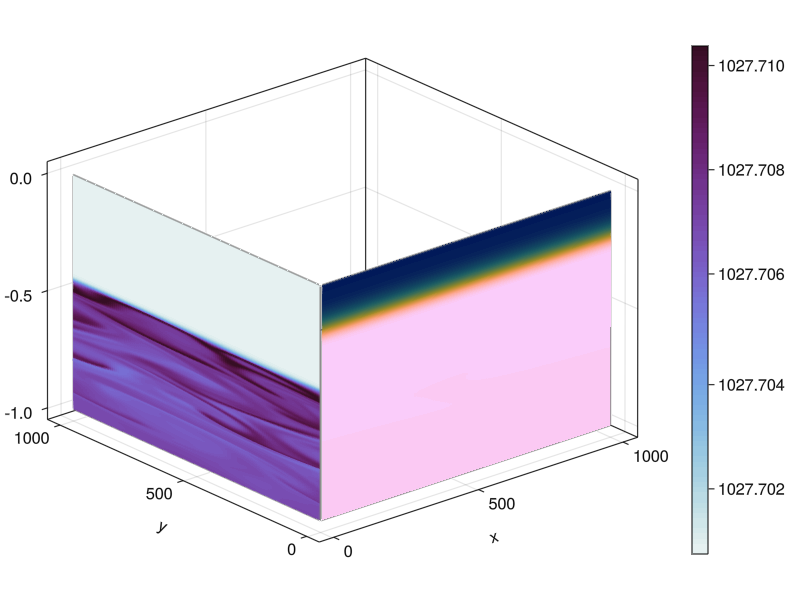

In [5]:
fig = Figure(size = (500, 500))
ax = Axis3(fig[1, 1])
# hidedecorations!(ax)
# hidespines!(ax)
vol_plot = volumeslices!(ax, cabbeling_x, 1:1000, cabbeling_z, cabbeling_density[:, :, :, 2], colormap = :dense)
volumeslices!(ax, 1:1000, cabbeling_x, cabbeling_z, cabbeling_density[:, :, :, 6], colormap = :batlow)
Colorbar(fig[1, 2], vol_plot)
fig

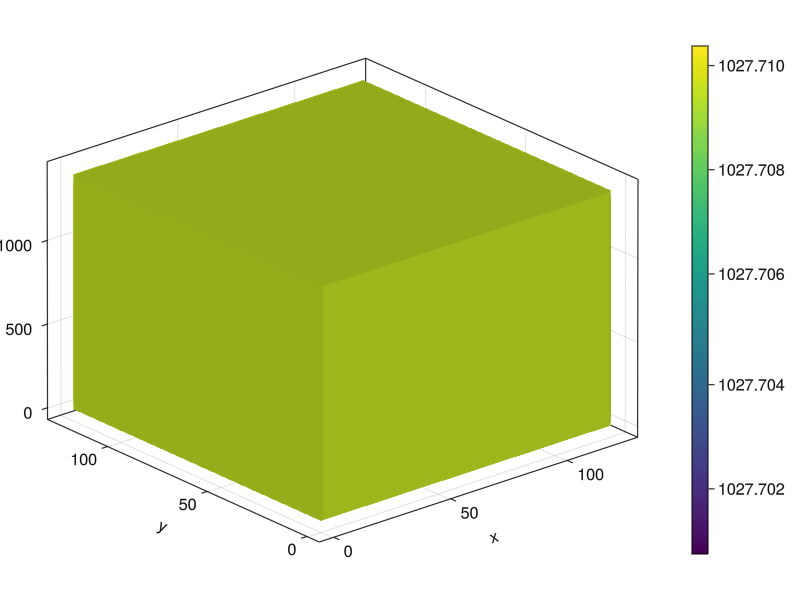

In [17]:
fig = Figure(size = (500, 500))
ax = Axis3(fig[1, 1])
# hidedecorations!(ax)
# hidespines!(ax)
vol_plot = volume!(ax, cabbeling_density[:, :, :, 2], algorithm = :iso, isovalue = cabbeling_density[50, 50, 700, 2])
Colorbar(fig[1, 2], vol_plot)
fig


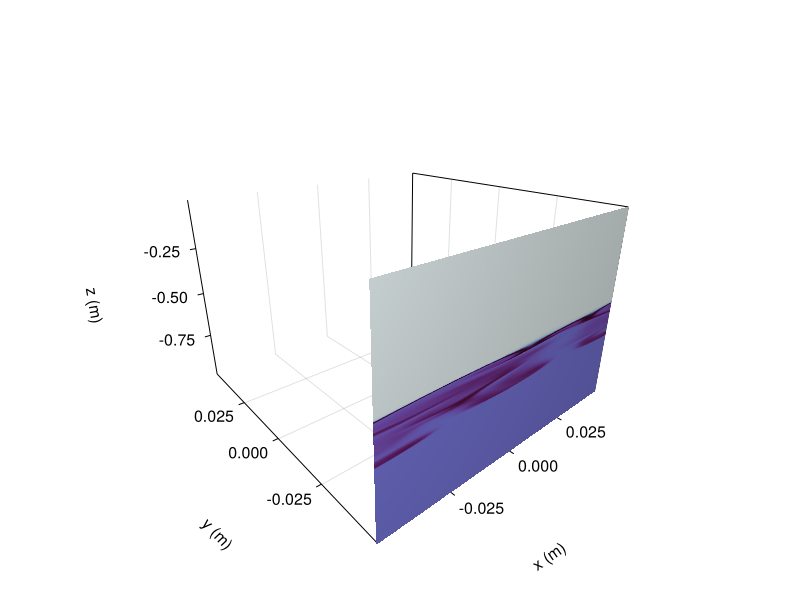

In [40]:
fig = Figure(size = (1600, 800))

ax = Axis3(fig[1, 1],
           # aspect=(1, 1, 1/5),
           xlabel = "x (m)",
           ylabel = "y (m)",
           zlabel = "z (m)",
           xlabeloffset = 100,
           ylabeloffset = 100,
           zlabeloffset = 100,
           limits = ((x[1], x[end]), (y[1], y[end]), (z[1], z[end])),
        #    elevation = 0.45,
        #    azimuth = 6.8,
           xspinesvisible = false,
           zgridvisible = false,
           protrusions = 40,
           perspectiveness = 0.7)

file = jldopen("density_and_w_snapshots.jld2")

x = file["σ/x"]
y = file["σ/y"]
z = file["σ/z"]
z_vel = file["w/z"]

x_xz = repeat(x, 1, length(z))
x_xy = repeat(x, 1, length(y))
y_xz = repeat(y, 1, length(z))
y_xy = repeat(y, 1, length(x))
z_xz = repeat(reshape(z, 1, length(z)), length(x), 1)
z_yz = repeat(reshape(z_vel, 1, length(z_vel)), length(x), 1)

x_xz_velocity = x[end] * ones(length(x), length(z))
y_xz_density = y[1] * ones(length(x), length(z))
z_xy_top = z[end] * ones(length(x), length(y))

snapshot = 10
slices = (east   = file["σ/σ_xzslice/σ_$(60.0 * snapshot)"],
          north  = file["w/w_yzslice/w_$(60.0 * snapshot)"],
          top    = file["σ/σ_xyslice/σ_$(60.0 * snapshot)"])

# # Zonally-averaged desity
# B = interior(B_timeseries[n], 1, :, :)

# clims = 1.1 .* extrema(b_timeserieses.top[n][:])

# kwargs = (colorrange=clims, colormap=:deep, shading=NoShading)

surface!(ax, x_xz, y_xz_density, z_xz; color = slices.east, colormap = :dense)
# surface!(ax, x_xz_velocity, y_xz, z_yz; color = slices.north, colormap = :balance)
surface!(ax, x_xy, y_xy, z_xy_top; color = slices.top, colormap = :dense)

# sf = surface!(ax, zonal_slice_displacement .* x_yz_east, y_yz, z_yz; color = B, kwargs...)

# contour!(ax, y, z, B; transformation = (:yz, zonal_slice_displacement * x[end]),
#          levels = 15, linewidth = 2, color = :black)

# Colorbar(fig[2, 2], sf, label = "m s⁻²", height = Relative(0.4), tellheight=false)

# title = "Buoyancy at t = " * string(round(times[n] / day, digits=1)) * " days"
# fig[1, 1:2] = Label(fig, title; fontsize = 24, tellwidth = false, padding = (0, 0, -120, 0))

# rowgap!(fig.layout, 1, Relative(-0.2))
# colgap!(fig.layout, 1, Relative(-0.1))

close(file)
fig

In [37]:
slices.north

124×1401 Matrix{Float64}:
 0.0  -1.89771e-14  -3.80127e-14  …   4.232e-16     2.5869e-16   0.0
 0.0  -1.93089e-14  -3.87005e-14      3.50671e-16   1.65644e-16  0.0
 0.0  -1.972e-14    -3.94228e-14      4.73934e-16   3.10174e-16  0.0
 0.0  -1.99164e-14  -3.98095e-14      5.29835e-16   3.54235e-16  0.0
 0.0  -2.00481e-14  -4.01868e-14      4.7379e-16    2.45681e-16  0.0
 0.0  -2.03436e-14  -4.06082e-14  …   3.12057e-16   1.30943e-16  0.0
 0.0  -2.03031e-14  -4.07038e-14      1.85281e-16   1.40423e-16  0.0
 0.0  -2.03598e-14  -4.0805e-14       2.63077e-16   1.59681e-16  0.0
 0.0  -2.04868e-14  -4.09765e-14      2.10911e-16   7.04542e-17  0.0
 0.0  -2.0385e-14   -4.08349e-14     -7.76866e-18  -1.21529e-17  0.0
 ⋮                                ⋱                              ⋮
 0.0  -1.4449e-14   -2.8945e-14   …  -2.92314e-16  -1.60885e-16  0.0
 0.0  -1.51809e-14  -3.03213e-14     -2.25732e-16  -1.61128e-16  0.0
 0.0  -1.57017e-14  -3.15046e-14     -4.35415e-16  -2.32206e-16  0.0
 0.0  -1.6